In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import pandas as pd
import json
from math import sin, cos, sqrt, atan2, radians

# Loading the files  

In [3]:
# migros and coop files
migros=pd.read_csv("../../data/processed/data_migros_final.csv")
coop=pd.read_csv("../../data/processed/coop.csv")
migros.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'business_status', 'formatted_address',
       'icon', 'icon_background_color', 'icon_mask_base_uri', 'name', 'photos',
       'place_id', 'rating', 'reference', 'types', 'user_ratings_total',
       'geometry.location.lat', 'geometry.location.lng',
       'geometry.viewport.northeast.lat', 'geometry.viewport.northeast.lng',
       'geometry.viewport.southwest.lat', 'geometry.viewport.southwest.lng',
       'opening_hours.open_now', 'plus_code.compound_code',
       'plus_code.global_code', 'permanently_closed', 'price_level'],
      dtype='object')

In [4]:
#density pop file
density_df=pd.read_csv("../../../migros/GeoFeatures_Zurich_provided_by_UrbanDataLabs.csv")
density_df=density_df.drop(columns=["noise_street","bldg_foot","bldg_corner"])
#density_df=density_df[density_df["pers_ha"]>200]
density_df.head(1)

x          y                                               geom  \
0  2682762.5  1246387.5  01010000200808000000000040C577444100000080B304...   

   hh_ha  pers_ha  pt_class  pt_dis  station_dis  bldg_500    net_acc  \
0      8       10       1.0      55         1725   1402050  1043508.0   

       lat      lng  
0  47.3631  8.53425

In [5]:
#df["lng"]=df['lng'].round(decimals = 4)

In [6]:
df_new = density_df.groupby(density_df['lng']).aggregate("first")

In [7]:
df_new.reset_index(inplace=True)

# Scatter map plot

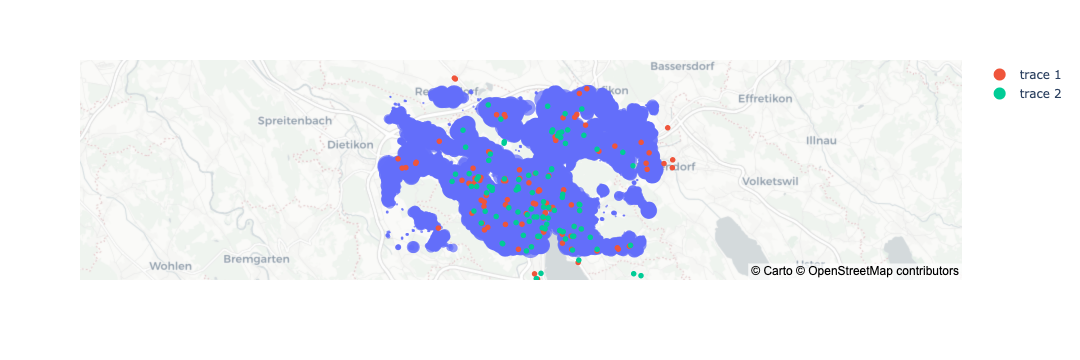

In [8]:
fig = px.scatter_mapbox(df_new, lat="lat", lon="lng",mapbox_style="carto-positron", zoom=10, size="pers_ha") #size="pers_ha", color="bldg_500")
fig.add_scattermapbox(lat=migros["geometry.location.lat"], lon=migros["geometry.location.lng"], mode = 'markers')
fig.add_scattermapbox(lat=coop["geometry.location.lat"], lon=coop["geometry.location.lng"], mode = 'markers')

fig.show()

# FINDING POSIBLE LOCATIONS FOR NEW STORES

In [9]:
def distance(lat1, lat2, lng1, lng2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lng1)
    lat2 = radians(lat2)
    lon2 = radians(lng2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c

    # km to miles
    distance /= 1.609344

    return distance

The following parameters define how far away the new store should be form the closest migros, (RAD).  NUM_PPL filters the dataframe "density_df" with points with persons per hectarea >NUM_PPL

In [19]:

# PARAMETERS:
NUM_PPL=150
RAD=0.25

mesh=density_df[density_df["pers_ha"]>NUM_PPL]
mesh=mesh[["lat", "lng"]]
mesh.shape

(11487, 2)

In [20]:
stores=pd.concat([migros, coop])


In [22]:
stores_lat = stores['geometry.location.lat'].to_numpy()
stores_lng = stores['geometry.location.lng'].to_numpy()
mesh_lat=mesh["lat"].to_numpy()
mesh_lng=mesh["lng"].to_numpy()
index_list=[]

for i in range(len(stores_lat)):
    for j in range(len(mesh_lat)):

         if distance(stores_lat[i],mesh_lat[j],stores_lng[i],mesh_lng[j])<RAD:
                index_list.append(j)
                
                
mesh_lat=np.delete(mesh_lat, index_list)
mesh_lng=np.delete(mesh_lng, index_list)

In [23]:
solutions = pd.DataFrame({"lat":mesh_lat})
solutions['lng'] = pd.Series(mesh_lng)

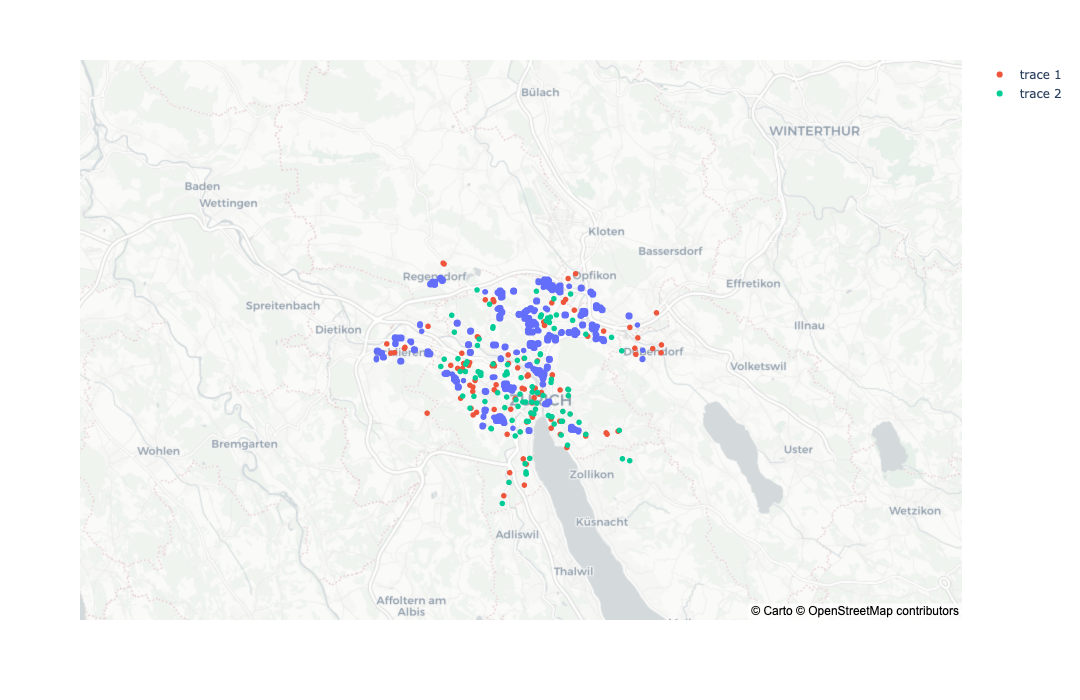

In [24]:
fig = px.scatter_mapbox(solutions, lat="lat", lon="lng",mapbox_style="carto-positron", zoom=10)
fig.add_scattermapbox(lat=migros["geometry.location.lat"], lon=migros["geometry.location.lng"], mode = 'markers',text="migros")
fig.add_scattermapbox(lat=coop["geometry.location.lat"], lon=coop["geometry.location.lng"], mode = 'markers',text="coop")
fig.update_layout(
    autosize=False,
    width=900,
    height=700)

fig.show()